In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Preparations
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from os.path import join
from collections import namedtuple

import numpy as np
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2
from scipy.special import erfinv
from settings import *  # contains all flux parameters
from resolution import energy_smearing
from mephisto import plot_mephistogram, plot_multiple_mephistograms

from tools import poisson_llh


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Default binning

In [4]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Get the effective area
The PLEnuM effective area is calculated in core/aeff_calculations.py

In [4]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])

with open(join(LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)

dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.47937914 13.47937914 16.64221592 ... 23.82743744  0.
   0.        ]
 [17.02848656 17.02848656 20.63478084 ... 20.27620928  0.
   0.        ]
 [19.13943583 19.13943583 22.97704711 ... 18.70430083  0.
   0.        ]]


## 2D effective area plot in log(energy) and sin(decl)

In [5]:
from matplotlib.colors import ListedColormap, LogNorm
cmap = ListedColormap(sns.color_palette("mako", n_colors=16))

### up-going effective area

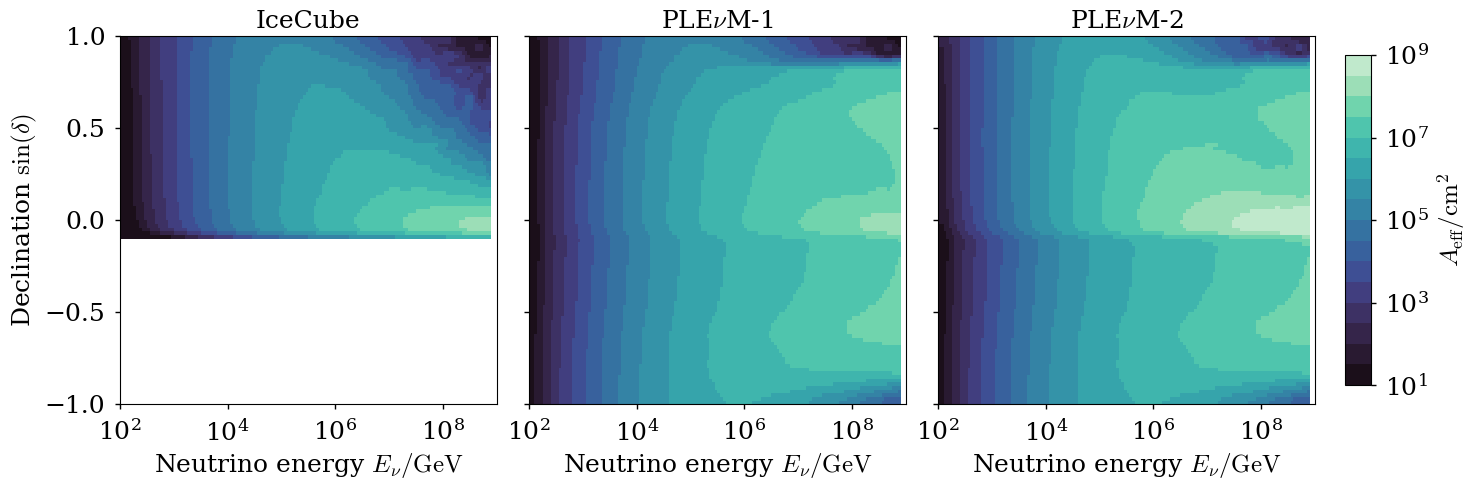

In [7]:
# horizontal
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-2"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_comparison_IC_PLENUM-1-2_upgoing.pdf"))


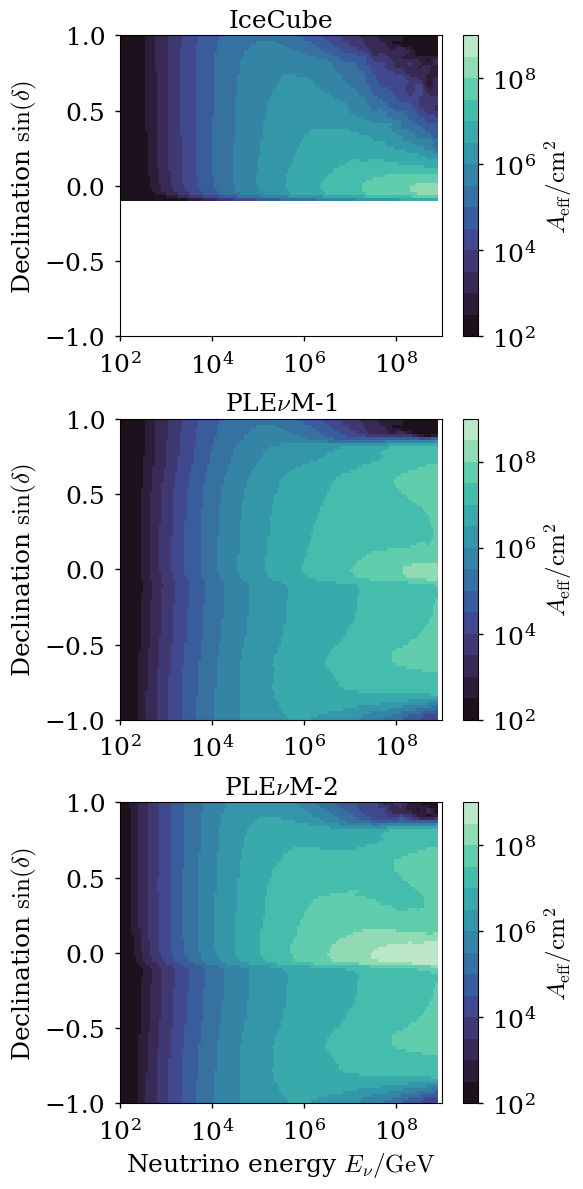

In [8]:
# vertical plot
cmap = ListedColormap(sns.color_palette("mako", n_colors=14))
log_col = LogNorm(
        vmin=1e2,
        vmax=1e9,
    )
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].histo,
    norm=log_col,
    cmap=cmap,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].histo,
    norm=log_col,
    cmap=cmap,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-2"].histo,
    norm=log_col,
    cmap=cmap,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")

for ax in axes:
    ax.set_ylabel(r"Declination $\sin(\delta)$")
    
fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_comparison_IC_PLENUM-1-2_upgoing_vertical.pdf"))


### full effective area

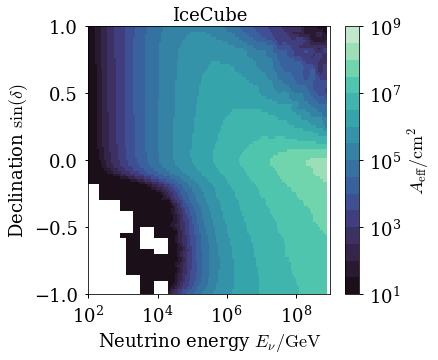

In [9]:
# IceCube only
fig, ax = plt.subplots(figsize=(6, 5), sharey=True)
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
cb = plt.colorbar(p)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")
ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
fig.savefig(join(BASEPATH, "plots/aeff_IC.png"))


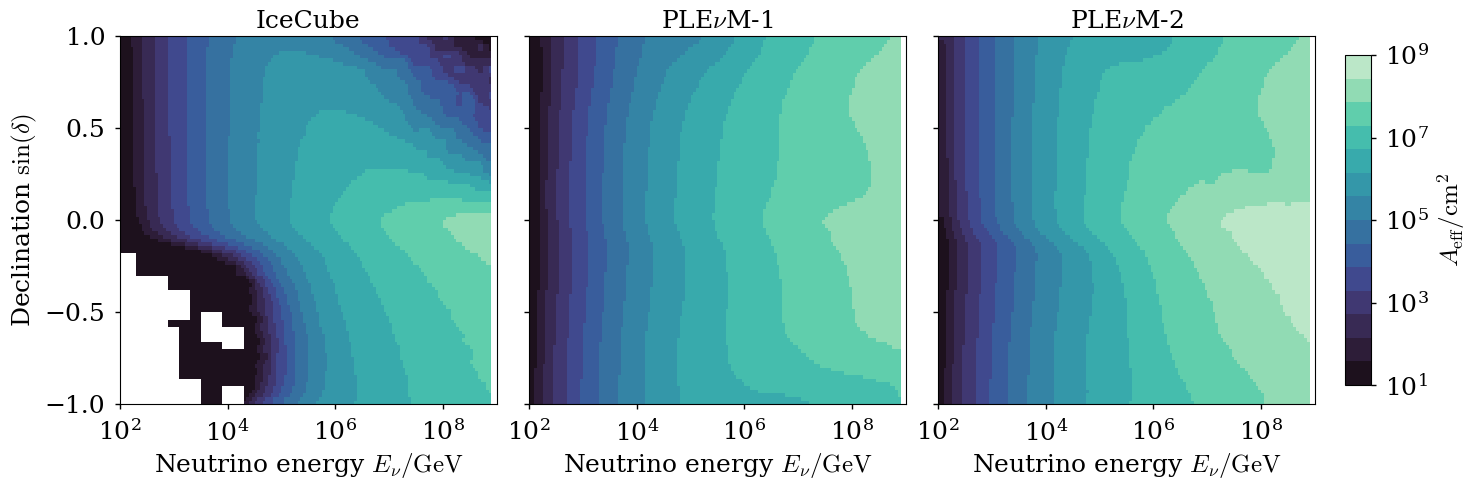

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-1"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-2"].histo,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_comparison_IC_PLENUM-1-2.pdf"))


# Additional effective area checking plots

In [10]:
from tools import reset_palette, slightly_change_color

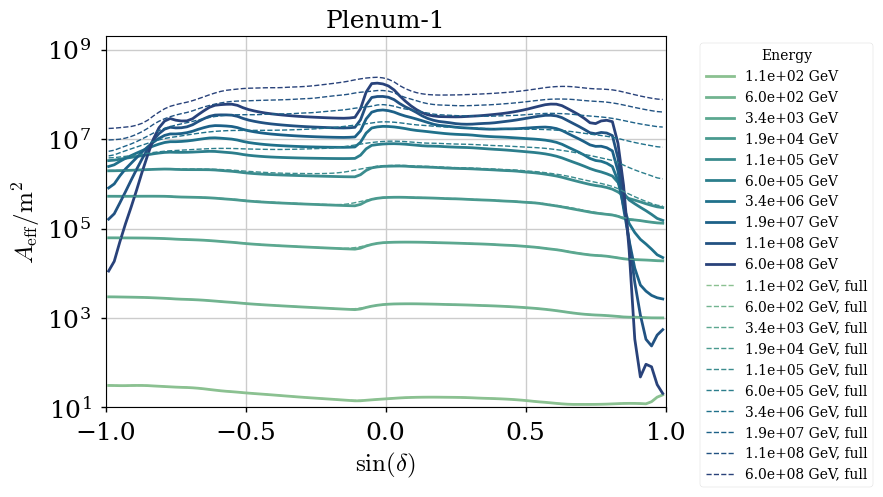

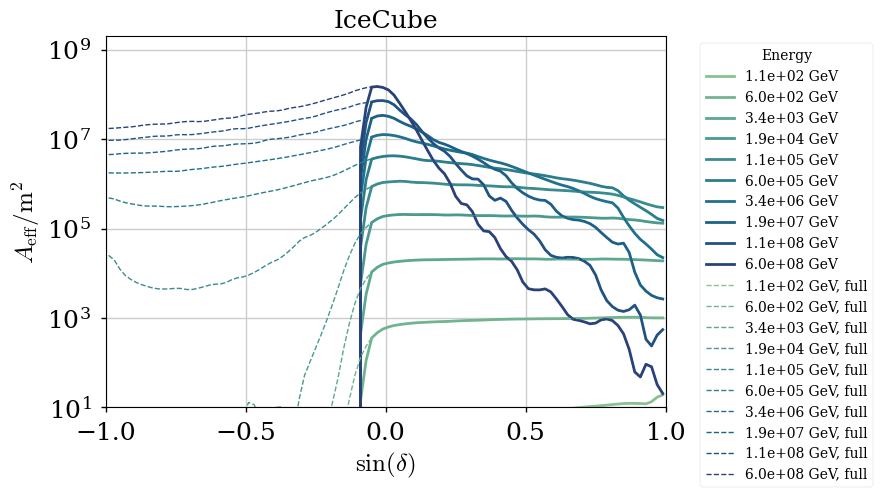

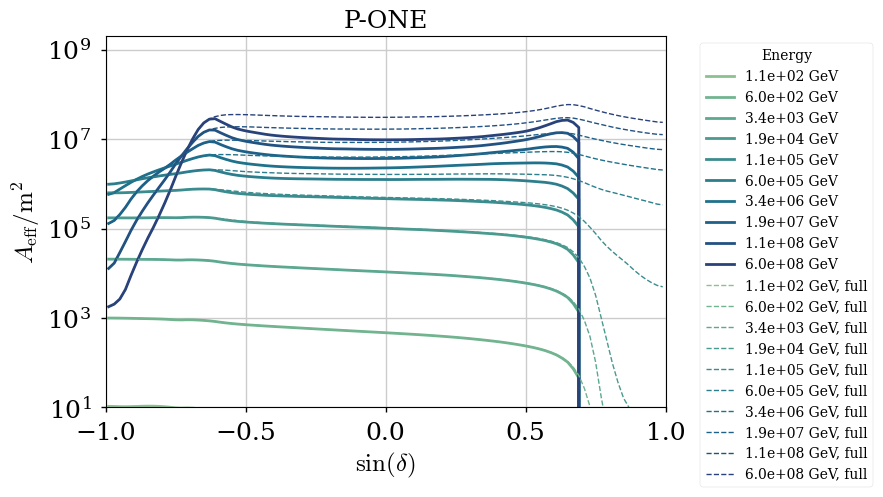

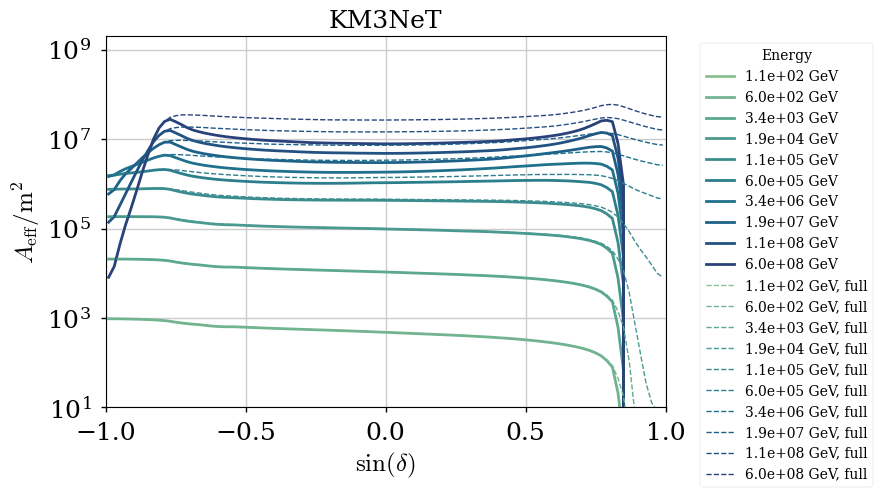

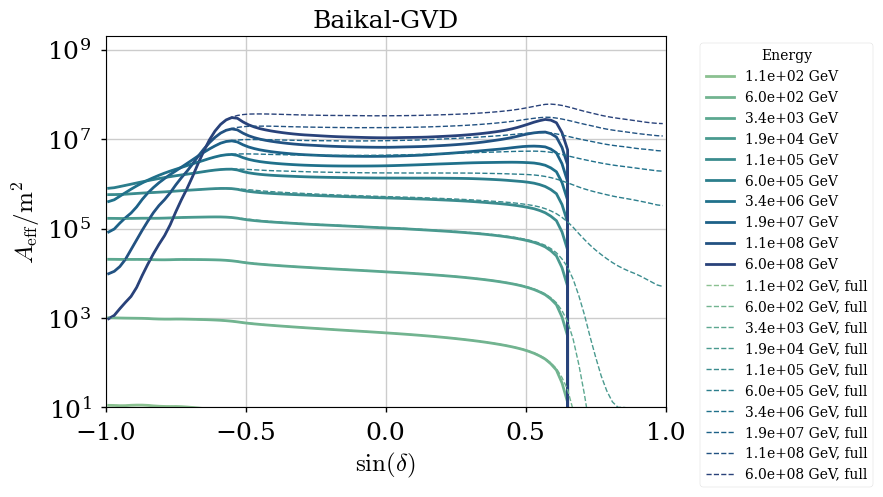

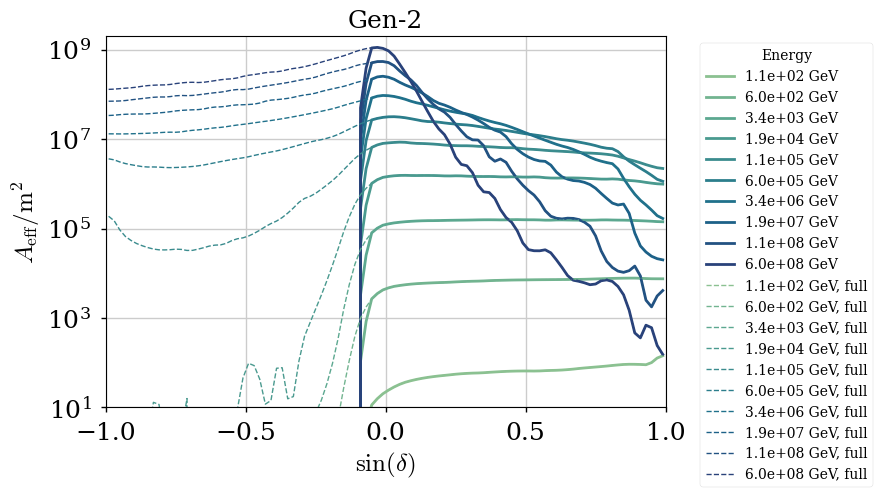

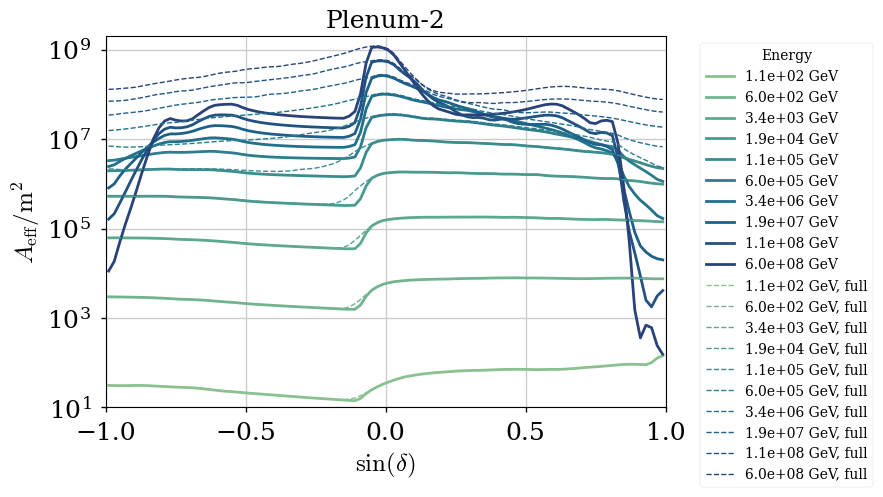

In [11]:
# slices in energy
factor = 15
nlines = len(emids) // factor + 1
reset_palette(nlines, sns)
mid_color = plt.rcParams["axes.prop_cycle"].by_key()["color"][nlines // 2]
for k in aeff_2d:
    plt.figure(figsize=(9, 5))
    for ie, ae in enumerate(aeff_2d[k].T()[::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-",  # rotated
            lw=2,
        )
    for ie, ae in enumerate(aeff_2d_full[k].T()[::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV, full",
            ls="--",  # rotated
            lw=1,
        )
    plt.yscale("log")
    plt.title(k)

    plt.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", title="Energy", fontsize="medium"
    )
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 2e9)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
